# Import

## Modules

In [72]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
from datetime import timedelta


 Setup path

In [2]:
PROJECT_ROOT = Path.cwd().parent.resolve()
sys.path.append(str(PROJECT_ROOT))

## Scripts

In [3]:
from src.data.make_dataset import get_cases_data, to_datetime, subset_latest_outbreak, get_daily_cases_stats

## Data

In [4]:
raw_cases_data = get_cases_data()

## Audit

In [5]:
raw_cases_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8964 entries, 0 to 8963
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   notification_date           8964 non-null   object 
 1   postcode                    8168 non-null   object 
 2   likely_source_of_infection  8964 non-null   object 
 3   lhd_2010_code               8157 non-null   object 
 4   lhd_2010_name               8157 non-null   object 
 5   lga_code19                  8157 non-null   float64
 6   lga_name19                  8157 non-null   object 
dtypes: float64(1), object(6)
memory usage: 490.3+ KB


In [6]:
raw_cases_data.head()

,notification_date,postcode,likely_source_of_infection,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19
0,2020-01-25,2134,Overseas,X700,Sydney,11300.0,Burwood (A)
1,2020-01-25,2121,Overseas,X760,Northern Sydney,16260.0,Parramatta (C)
2,2020-01-25,2071,Overseas,X760,Northern Sydney,14500.0,Ku-ring-gai (A)
3,2020-01-27,2033,Overseas,X720,South Eastern Sydney,16550.0,Randwick (C)
4,2020-03-01,2077,Overseas,X760,Northern Sydney,14000.0,Hornsby (A)


# Preprocess data

In [7]:
raw_cases_data = to_datetime('notification_date', raw_cases_data)
data = subset_latest_outbreak('2021-06-01', 'Overseas', raw_cases_data)

In [8]:
data = get_daily_cases_stats(data)

In [9]:
data

,notification_date,Daily Number of Cases,Pct Change,Cumsum,Daily Difference,Growth Factor,Weekly Rolling Average,Epidemiological Days
0,2021-06-16,3,NaN,3,NaN,NaN,NaN,-9.0
1,2021-06-17,1,-0.666667,4,-2.0,NaN,NaN,-8.0
2,2021-06-18,2,1.000000,6,1.0,-0.500000,NaN,-7.0
3,2021-06-19,1,-0.500000,7,-1.0,-1.000000,NaN,-6.0
4,2021-06-20,2,1.000000,9,1.0,-1.000000,NaN,-5.0
5,2021-06-21,5,1.500000,14,3.0,3.000000,NaN,-4.0
6,2021-06-22,17,2.400000,31,12.0,4.000000,4.428571,-3.0
7,2021-06-23,12,-0.294118,43,-5.0,-0.416667,5.714286,-2.0
8,2021-06-24,21,0.750000,64,9.0,-1.800000,8.571429,-1.0
9,2021-06-25,28,0.333333,92,7.0,0.777778,12.285714,0.0


In [69]:
mask = data['Epidemiological Days'] == 0
initial_number_of_cases = data.loc[mask, 'Daily Number of Cases'].values[0]

mask = data['Epidemiological Days'] >= 0
daily_number_of_cases_std = data.loc[mask, 'Daily Number of Cases'].std()
average_growth_factor = data.loc[mask, 'Growth Factor'].mean()
std_growth_factor = data.loc[mask, 'Growth Factor'].std()

X = data.loc[mask, "Epidemiological Days"].values
y = data.loc[mask, "Weekly Rolling Average"].values

forecast_ndays = 7
X_forecast = np.append(X, list(np.arange(X.max(), X.max() + forecast_ndays)))


In [24]:
# Create PyMC3 context manager
with pm.Model() as model:
    t = pm.Data("X", X)
    cases = pm.Data("y", y)

    # Intercept - We fixed this at 100.
    a = pm.Normal("a", mu=initial_number_of_cases, sigma=daily_number_of_cases_std)

    # Slope - Growth rate: 0.2 is approx value reported by others
    b = pm.Normal("b", mu=average_growth_factor, sigma=std_growth_factor)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
    pm.Lognormal("cases", mu=np.log(growth), sigma=eps, observed=cases)

    trace = pm.sample()
    post_Pred = pm.sample_posterior_predictive(trace)

/tmp/ipykernel_744/915058442.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.879913564927489, but should be close to 0.8. Try to increase the number of tuning steps.


/tmp/ipykernel_744/851248946.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/home/vscode/.local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


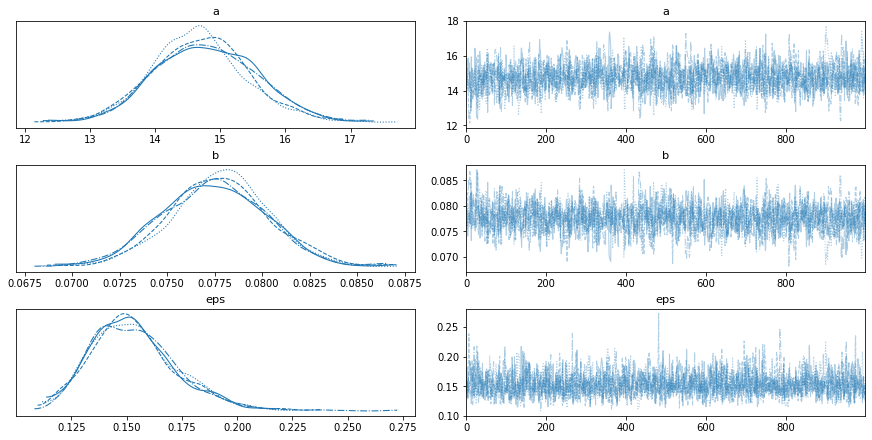

In [25]:
pm.traceplot(trace)
plt.show()

In [26]:
pm.summary(trace).round(2)

/home/vscode/.local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,14.74,0.77,13.34,16.23,0.02,0.02,1388.0,1523.0,1.0
b,0.08,0.00,0.07,0.08,0.00,0.00,1404.0,1461.0,1.0
eps,0.15,0.02,0.12,0.19,0.00,0.00,1963.0,2000.0,1.0


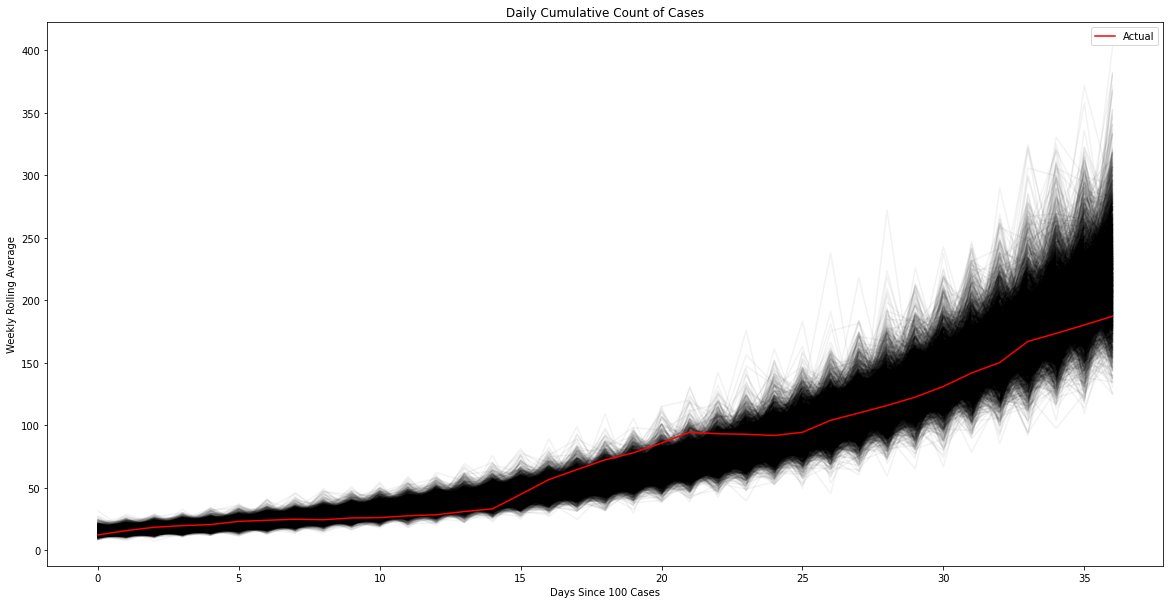

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(data.loc[mask, "Epidemiological Days"], post_Pred["cases"].T, color="k", alpha=0.05)
ax.plot(data.loc[mask, "Epidemiological Days"], data.loc[mask, "Weekly Rolling Average"], color="r", label="Actual")
# ax.set_yscale("log")
ax.set(xlabel="Days Since 100 Cases", ylabel="Weekly Rolling Average", title="Daily Cumulative Count of Cases")
ax.legend()
# plt.show()

In [33]:
# Update data reference.
pm.set_data({"X": X_forecast}, model=model)
# Generate posterior samples.
ppc_test = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [53]:
forecast_std = np.std(ppc_test["cases"].T, axis=1)

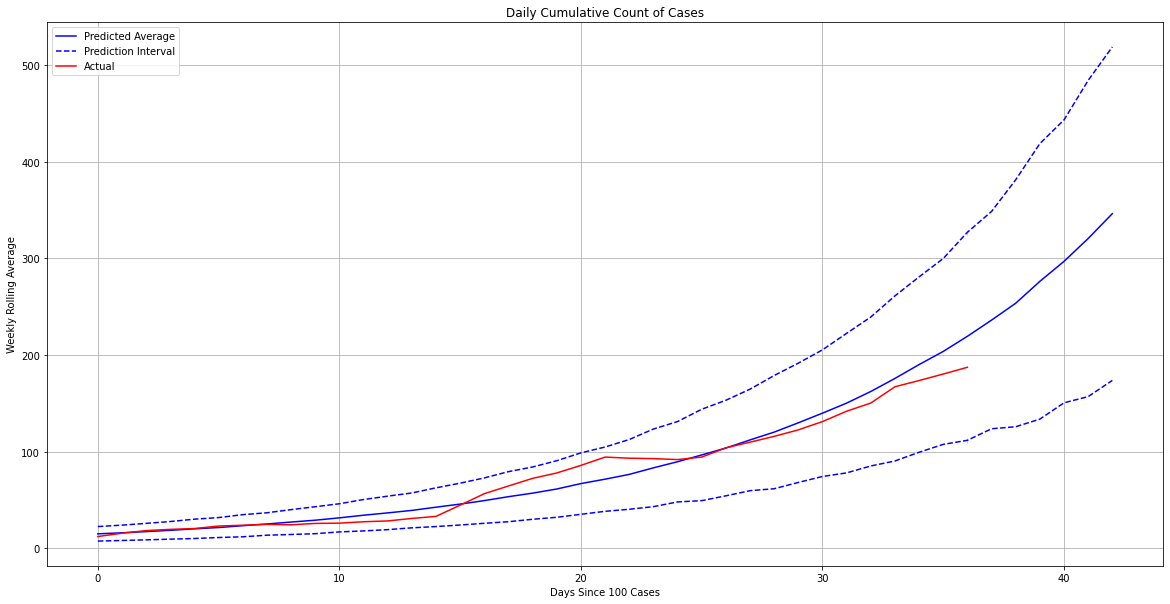

In [55]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(x=X_forecast, y=np.mean(ppc_test["cases"].T, axis=1), color="b", label="Predicted Weekly Rolling Average", ax=ax)
ax = sns.lineplot(x=X_forecast, y=np.mean(ppc_test["cases"].T, axis=1) + 3*forecast_std, color="b", linestyle="--", label="Prediction Interval", ax=ax)
ax = sns.lineplot(x=X_forecast, y=np.mean(ppc_test["cases"].T, axis=1) - 3*forecast_std, color="b", linestyle="--", ax=ax)
ax = sns.lineplot(x=data.loc[mask, "Epidemiological Days"], y=data.loc[mask, "Weekly Rolling Average"], color="r", label="Actual", ax=ax)

# ax.set_yscale("log")
ax.set(xlabel="Days Since 100 Cases", ylabel="Weekly Rolling Average", title="Daily Cumulative Count of Cases")
ax.legend()
ax.grid()

In [57]:
data_forecast = pd.DataFrame({"Epidemiological Days": X_forecast, "Predicted Weekly Rolling Average": np.mean(ppc_test["cases"].T, axis=1)})
data_forecast = data_forecast.merge(data[["notification_date", "Epidemiological Days"]], on="Epidemiological Days")
data_forecast

In [63]:
data_forecast.merge(data[["notification_date", "Epidemiological Days"]], on="Epidemiological Days", how="left")


,Epidemiological Days,Predicted Weekly Rolling Average,notification_date
0,0.0,15.096425,2021-06-25
1,1.0,16.146784,2021-06-26
2,2.0,17.381492,2021-06-27
3,3.0,18.701301,2021-06-28
4,4.0,20.244279,2021-06-29
5,5.0,21.591229,2021-06-30
6,6.0,23.469721,2021-07-01
7,7.0,25.267955,2021-07-02
8,8.0,27.263132,2021-07-03
9,9.0,29.177946,2021-07-04


In [62]:
X_forecast.shape

(44,)

In [71]:

for day in range(1, forecast_ndays):
    print(data["notification_date"].max() + timedelta(days=day))

2021-08-01 00:00:00
2021-08-02 00:00:00
2021-08-03 00:00:00
2021-08-04 00:00:00
2021-08-05 00:00:00
2021-08-06 00:00:00


In [ ]:
np.append(data["notification_date"].values, np.array([data["notification_date"].max() + timedelta(days=day) for day in range(1, forecast_ndays)]))